In [ ]:
# ✅ Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2

In [ ]:
# ✅ Step 2: Unzip the dataset

zip_path = '/content/drive/MyDrive/topic4_release.zip'
extract_path = '/content/'

if not os.path.exists(os.path.join(extract_path, 'topic4_release')):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [ ]:

# ✅ Step 3: Collect im1, im2, im3 from both High_Resolution and Low_Resolution
from tqdm import tqdm


def collect_paths_v2(res_type='High_Resolution'):
    base_path = f'/content/train/{res_type}'
    video_folders = sorted(glob.glob(f'{base_path}/*/*'))
    print(video_folders)
    path_list = []

    for folder in video_folders:
        frame_paths = [os.path.join(folder, f'im{i}.png') for i in range(1, 8)]
        if not all(os.path.exists(p) for p in frame_paths):
            continue

        for i in range(5):
            f0 = frame_paths[i]
            gt = frame_paths[i+1]
            f2 = frame_paths[i+2]
            path_list.append((f0, gt, f2))
    return path_list


In [ ]:
# ✅ Step 4: Install dependencies
!pip install torch torchvision

In [ ]:
# ✅ Step 5: Optical flow function using OpenCV
def compute_flow(f0, f1):
    gray0 = cv2.cvtColor(f0, cv2.COLOR_BGR2GRAY)
    gray1 = cv2.cvtColor(f1, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(gray0, gray1, None,
                                        0.5, 3, 15, 3, 5, 1.2, 0)
    return flow

In [ ]:
# ✅ Step 6: Prepare dataset with flow + augmentation
import torch
from torch.utils.data import Dataset

class InterpolationDatasetWithFlowCache(torch.utils.data.Dataset):
    def __init__(self, cached_triplets):
        self.cached_triplets = cached_triplets
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((256, 256))
        ])

    def __len__(self):
        return len(self.cached_triplets)

    def __getitem__(self, idx):
        f0_path, gt_path, f2_path, flow_path = self.cached_triplets[idx]

        f0 = Image.open(f0_path).convert('RGB')
        gt = Image.open(gt_path).convert('RGB')
        f2 = Image.open(f2_path).convert('RGB')

        f0 = self.transform(f0)
        gt = self.transform(gt)
        f2 = self.transform(f2)

        flow = np.load(flow_path)  # shape (H, W, 2)
        # optical flow resize
        flow_resized = cv2.resize(flow, (256, 256), interpolation=cv2.INTER_LINEAR)
        flow_resized = torch.tensor(flow_resized).permute(2, 0, 1).float() / 255.0

        input_tensor = torch.cat([f0, f2, flow_resized], dim=0)

        return input_tensor, gt




In [21]:
import os
import numpy as np

flow_cache_dir = '/content/flow_cache_updated'
os.makedirs(flow_cache_dir, exist_ok=True)

def preprocess_and_cache_flow(triplet_paths):
    cached_paths = []
    for f0_path, gt_path, f2_path in tqdm(triplet_paths):
        # 取得前三層資料夾名稱
        level1 = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(f0_path))))  # data
        level2 = os.path.basename(os.path.dirname(os.path.dirname(f0_path)))                  # dataset
        level3 = os.path.basename(os.path.dirname(f0_path))                                  # train

        base0 = os.path.splitext(os.path.basename(f0_path))[0]
        base2 = os.path.splitext(os.path.basename(f2_path))[0]

        flow_file_name = f"{level1}_{level2}_{level3}_{base0}_{base2}.npy"
        flow_file = os.path.join(flow_cache_dir, flow_file_name)

        if os.path.exists(flow_file):
            cached_paths.append((f0_path, gt_path, f2_path, flow_file))
            continue

        f0_img = cv2.imread(f0_path)
        f2_img = cv2.imread(f2_path)
        if f0_img is None or f2_img is None:
            print(f"⚠️ Failed to read {f0_path} or {f2_path}")
            continue

        flow = compute_flow(f0_img, f2_img)
        np.save(flow_file, flow)
        cached_paths.append((f0_path, gt_path, f2_path, flow_file))

    return cached_paths


In [22]:
from torch.utils.data import DataLoader

# 準備資料路徑清單
# 先收集前 500 筆
high_paths = collect_paths_v2('High_Resolution')[:2000]
low_paths = collect_paths_v2('Low_Resolution')[:2000]
all_paths = high_paths + low_paths


# 預處理光流並快取路徑
cached_triplets = preprocess_and_cache_flow(all_paths)

# 建立 Dataset 與 Dataloader
dataset = InterpolationDatasetWithFlowCache(cached_triplets)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

['/content/train/High_Resolution/00001/0266', '/content/train/High_Resolution/00001/0268', '/content/train/High_Resolution/00001/0275', '/content/train/High_Resolution/00001/0278', '/content/train/High_Resolution/00001/0285', '/content/train/High_Resolution/00001/0287', '/content/train/High_Resolution/00001/0291', '/content/train/High_Resolution/00001/0619', '/content/train/High_Resolution/00001/0622', '/content/train/High_Resolution/00001/0625', '/content/train/High_Resolution/00001/0627', '/content/train/High_Resolution/00001/0628', '/content/train/High_Resolution/00001/0629', '/content/train/High_Resolution/00001/0632', '/content/train/High_Resolution/00001/0636', '/content/train/High_Resolution/00001/0638', '/content/train/High_Resolution/00001/0643', '/content/train/High_Resolution/00001/0646', '/content/train/High_Resolution/00001/0783', '/content/train/High_Resolution/00001/0786', '/content/train/High_Resolution/00001/0790', '/content/train/High_Resolution/00001/0791', '/content

100%|██████████| 4000/4000 [02:01<00:00, 33.01it/s]


In [23]:
import torch

print("CUDA 可用：" , torch.cuda.is_available())
print("使用的 GPU 名稱：" , torch.cuda.get_device_name(0))

CUDA 可用： True
使用的 GPU 名稱： Tesla T4


In [24]:
import torch.nn as nn

class SimpleInterpNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(8, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU()
        )

        self.middle = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x


In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleInterpNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.L1Loss()

# Training
epochs = 15
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        preds = model(inputs)
        loss = loss_fn(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(dataloader):.4f}")


Epoch 1/15 - Loss: 0.0672
Epoch 2/15 - Loss: 0.0334
Epoch 3/15 - Loss: 0.0303
Epoch 4/15 - Loss: 0.0291
Epoch 5/15 - Loss: 0.0261
Epoch 6/15 - Loss: 0.0219
Epoch 7/15 - Loss: 0.0209
Epoch 8/15 - Loss: 0.0208
Epoch 9/15 - Loss: 0.0196
Epoch 10/15 - Loss: 0.0197
Epoch 11/15 - Loss: 0.0189
Epoch 12/15 - Loss: 0.0187
Epoch 13/15 - Loss: 0.0182
Epoch 14/15 - Loss: 0.0181
Epoch 15/15 - Loss: 0.0177


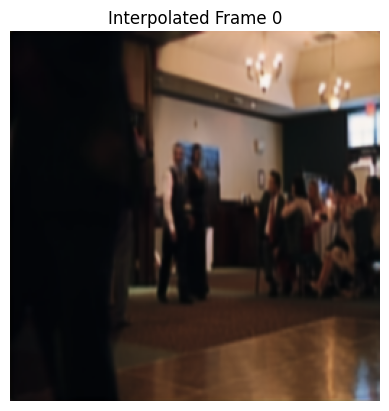

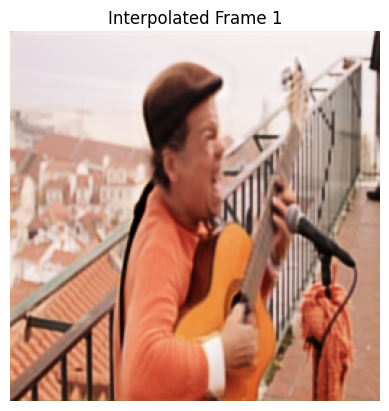

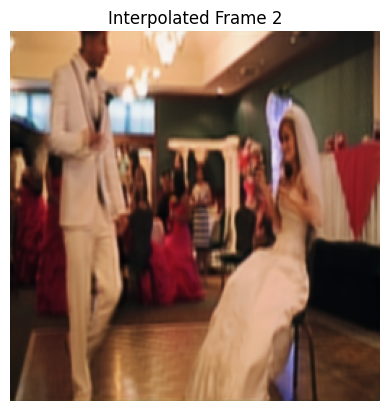

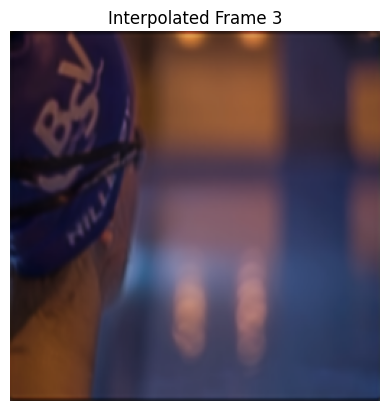

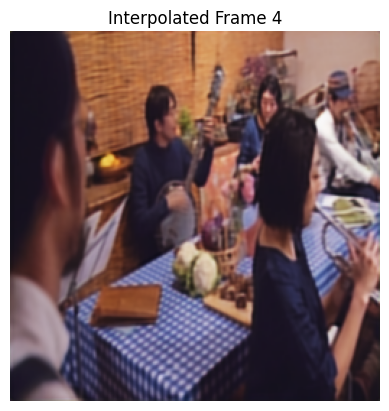

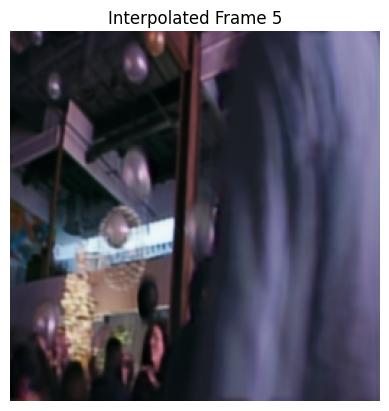

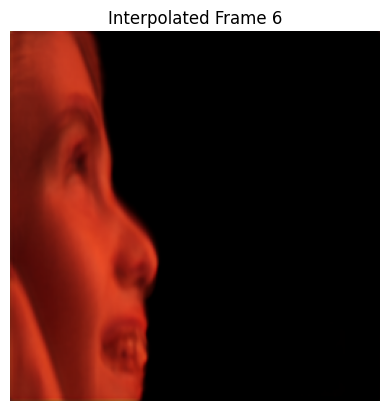

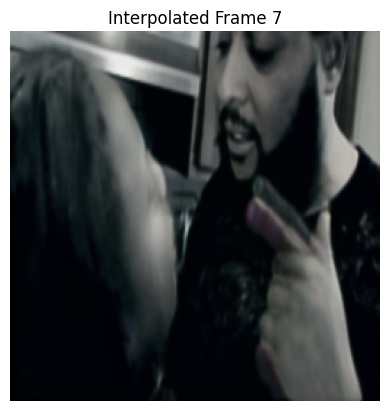

In [26]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import os

# 新增：建立存放插值影格的資料夾
output_dir = '/content/interpolated_frames'
os.makedirs(output_dir, exist_ok=True)

model.eval()
with torch.no_grad():
    # 從 dataloader 取出第一批資料（8張）
    inputs, targets = next(iter(dataloader))
    inputs = inputs.to(device)

    preds = model(inputs)  # 預測插值影格

    for i in range(preds.size(0)):
        pred_img = preds[i].cpu()
        # Tensor 轉成 PIL Image
        pil_img = TF.to_pil_image(pred_img)

        # 顯示圖片（可選）
        plt.imshow(pil_img)
        plt.title(f'Interpolated Frame {i}')
        plt.axis('off')
        plt.show()

        # 存成 PNG 檔
        pil_img.save(f"{output_dir}/interp_{i}.png")


In [27]:
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim_func
from skimage.metrics import peak_signal_noise_ratio as psnr_func

def compute_ssim(img1, img2):
    # Input: torch tensors (C, H, W)
    img1_np = img1.permute(1, 2, 0).cpu().numpy()
    img2_np = img2.permute(1, 2, 0).cpu().numpy()
    return ssim_func(img1_np, img2_np, data_range=1.0, channel_axis=2)

def compute_psnr(img1, img2):
    img1_np = img1.permute(1, 2, 0).cpu().numpy()
    img2_np = img2.permute(1, 2, 0).cpu().numpy()
    return psnr_func(img1_np, img2_np, data_range=1.0)

In [28]:
# 推論 + 評估
model.eval()
ssim_scores = []
psnr_scores = []

with torch.no_grad():
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        preds = model(inputs)

        for i in range(preds.shape[0]):
            pred = preds[i]
            gt = targets[i]

            psnr = compute_psnr(pred, gt)
            ssim = compute_ssim(pred, gt)

            psnr_scores.append(psnr)
            ssim_scores.append(ssim)

avg_psnr = sum(psnr_scores) / len(psnr_scores)
avg_ssim = sum(ssim_scores) / len(ssim_scores)

print(f"\n✅ Evaluation Finished:")
print(f"📈 Average PSNR: {avg_psnr:.2f}")
print(f"📈 Average SSIM: {avg_ssim:.4f}")


✅ Evaluation Finished:
📈 Average PSNR: 30.57
📈 Average SSIM: 0.9022


In [31]:
def interpolate_and_evaluate(frame0_path, frame1_path, frame2_path, model):
    # 1. 讀圖
    f0_img_cv2 = cv2.imread(frame0_path)
    f2_img_cv2 = cv2.imread(frame2_path)
    if f0_img_cv2 is None or f2_img_cv2 is None:
        raise ValueError("⚠️ 讀取 frame0 或 frame2 失敗")

    # 2. 計算 Optical Flow
    flow = compute_flow(f0_img_cv2, f2_img_cv2)
    flow_resized = cv2.resize(flow, (256, 256), interpolation=cv2.INTER_LINEAR)
    flow_tensor = torch.tensor(flow_resized).permute(2, 0, 1).float() / 255.0

    # 3. 預處理 f0 和 f2
    f0_tensor = load_and_preprocess_image(frame0_path)
    f2_tensor = load_and_preprocess_image(frame2_path)

    # 4. 組成模型輸入
    input_tensor = torch.cat([f0_tensor, f2_tensor, flow_tensor], dim=0).unsqueeze(0).to(device)

    # 5. 預測插值影格
    model.eval()
    with torch.no_grad():
        pred = model(input_tensor)[0].cpu()  # shape: (3, 256, 256)

    # 6. 預處理 ground truth
    gt_tensor = load_and_preprocess_image(frame1_path)

    # 7. 計算 Residual（差異）
    residual = torch.abs(gt_tensor - pred).clamp(0, 1)  # 絕對差 + 限制範圍在 [0,1]

    # 8. 計算 PSNR & SSIM
    psnr = compute_psnr(pred, gt_tensor)
    ssim = compute_ssim(pred, gt_tensor)

    # 9. 顯示三張圖：預測、GT、Residual
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(TF.to_pil_image(pred))
    plt.title("🔮 Interpolated Frame")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(TF.to_pil_image(gt_tensor))
    plt.title("🎯 Ground Truth (Frame1)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(TF.to_pil_image(residual))
    plt.title("📉 Residual (|GT - Pred|)")
    plt.axis('off')

    plt.show()

    print(f"📈 PSNR: {psnr:.2f}")
    print(f"📈 SSIM: {ssim:.4f}")

    return pred, psnr, ssim, residual



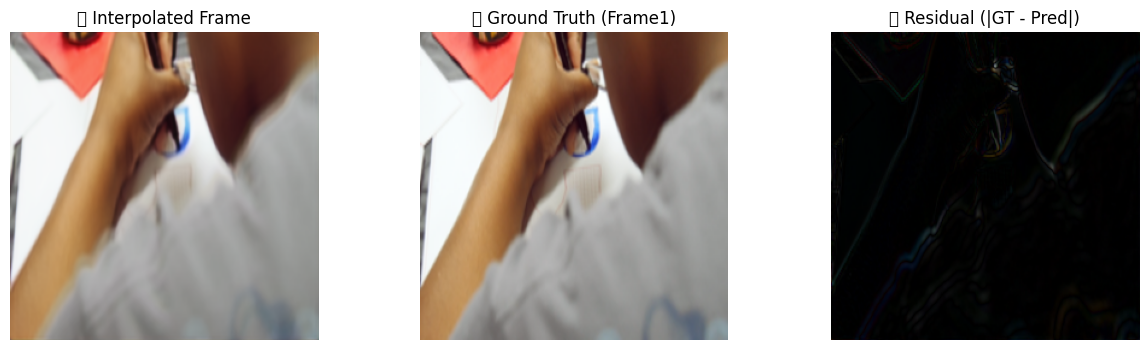

📈 PSNR: 32.09
📈 SSIM: 0.9404


In [33]:
# 輸入你的三張圖片路徑
frame0_path = '/content/public_test_set/00071/0117/im1.png'
frame1_path = '/content/public_test_set/00071/0117/im2.png'  # ground truth
frame2_path = '/content/public_test_set/00071/0117/im3.png'

# 呼叫函式
pred_frame, psnr, ssim, residual = interpolate_and_evaluate(
    frame0_path, frame1_path, frame2_path, model
)